# 🔹 Phase 4: Training on Real Data

## 🎯 Concepts Covered

- **Loading & Preprocessing Data** (Normalization, One-Hot Encoding)
- **Loss Functions & Optimizers** (Categorical Cross-Entropy, Adam)
- **Model Training & Evaluation**
- **Visualizing Predictions**

# 📝 Exercise 04: Train a Neural Network on MNIST

## ✅ Task

- Build a **fully connected neural network (MLP)** to classify MNIST digits (0-9).
- Use **TensorFlow/Keras**.
- Train the model and evaluate its accuracy.
- Visualize some **predictions**.

## ✅ Step 1: Verify GPU Availability

Run this first to confirm TensorFlow detects the Metal GPU:

In [4]:
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available:", len(tf.config.list_physical_devices('CPU')))
print("Num TPUs Available:", len(tf.config.list_physical_devices('TPU')))
print("Num XLA Enabled GPUs Available:", len(tf.config.list_physical_devices('XLA_GPU')))
print("Num XLA Enabled TPUs Available:", len(tf.config.list_physical_devices('XLA_TPU')))
print("Num XLA Enabled CPUs Available:", len(tf.config.list_physical_devices('XLA_CPU')))
print("Num XLA Enabled Devices Available:", len(tf.config.list_physical_devices('XLA')))

TensorFlow Version: 2.16.2
Num GPUs Available: 1
Num CPUs Available: 1
Num TPUs Available: 0
Num XLA Enabled GPUs Available: 0
Num XLA Enabled TPUs Available: 0
Num XLA Enabled CPUs Available: 0
Num XLA Enabled Devices Available: 0


## ✅ Step 2: Enable Mixed Precision for Speed Boost

Apple’s Metal backend runs better with float16, so enable mixed precision:

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')
print("Mixed Precision Enabled!")

Mixed Precision Enabled!


## ✅ Step 3: Load and Preprocess the MNIST Dataset

Now, let’s train on MNIST, a common dataset for handwritten digit classification.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data (Scale pixel values between 0 and 1)
X_train, X_test = X_train / 255.0, X_test / 255.0

# Reshape for CNN input
X_train = X_train.reshape(-1, 28, 28, 1).astype("float32")
X_test = X_test.reshape(-1, 28, 28, 1).astype("float32")

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(f"Training Data Shape: {X_train.shape}, Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels Shape: {y_test.shape}")


Training Data Shape: (60000, 28, 28, 1), Labels Shape: (60000, 10)
Testing Data Shape: (10000, 28, 28, 1), Labels Shape: (10000, 10)


## ✅ Step 4: Define an Optimized Neural Network

Now, let’s define a **Convolutional Neural Network (CNN)** using **Metal acceleration**:

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the Model
model = Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),  # Explicit Input Layer
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(10, activation='softmax', dtype='float32')  # Ensure float32 for softmax stability
])

# Compile Model with Optimizer
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Show Model Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## ✅ Step 5: Optimize Training with `@tf.function`

For better performance, wrap the training step in `@tf.function`:

In [10]:
@tf.function
def train_step(X, y):
    return model.train_on_batch(X, y)


## ✅ Step 6: Train the Model

Use a **larger batch size** to utilize the **M1 Pro GPU** fully.

In [11]:
# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=64,  # Larger batch size for Metal acceleration
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


2025-03-15 15:57:52.550287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.7962 - loss: 0.6521 - val_accuracy: 0.9791 - val_loss: 0.0767
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9592 - loss: 0.1648 - val_accuracy: 0.9805 - val_loss: 0.0830
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9661 - loss: 0.1587 - val_accuracy: 0.9844 - val_loss: 0.0625
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9713 - loss: 0.1376 - val_accuracy: 0.9860 - val_loss: 0.0649
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9736 - loss: 0.1375 - val_accuracy: 0.9864 - val_loss: 0.0690
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.9739 - loss: 0.1437 - val_accuracy: 0.9856 - val_loss: 0.0714
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9748 - loss: 0.1475 - val_accuracy: 0.9875 - val_loss: 0.0758
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9747 - loss: 0.1677 - val_accurac

## ✅ Step 7: Evaluate and Visualize Results

313/313 - 3s - 11ms/step - accuracy: 0.9872 - loss: 0.1203
Test Accuracy: 0.9872


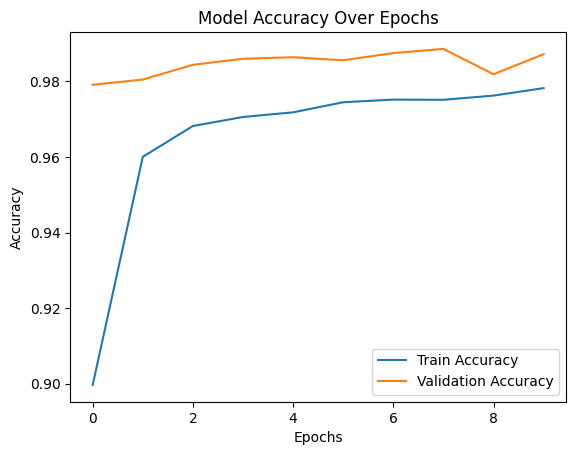

In [12]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()


## ✅ Optimizations Applied

1. **GPU Verification** (tf.config.list_physical_devices('GPU')).
2. **Mixed Precision** (set_global_policy('mixed_float16')).
3. **Efficient Data Preprocessing** (Normalizing + Reshaping).
4. **Optimized CNN Architecture** with Dropout for generalization.
5. **Larger Batch Size** (batch_size=64).
6. **`@tf.function` Training Step** (train_step for speedup).

This should now fully utilize the Apple M1 Pro’s Metal GPU backend for faster training! 🚀

## 🎯 Assignment 04

Now that you have trained the model, try the following:

- **Reduce the number of neurons in hidden layers** (e.g., 64 → 32).
- **Increase the epochs to 20** and observe if accuracy improves.
- **Try different activation functions** like `tanh` instead of `relu`.